# Data preparation

## emotion label + path to file

In [13]:
#!/home/judehey/miniconda3/envs/myenv/bin/python

import pandas as pd
import numpy as np
import os

pathToData="../data/emodb/wav/"
imgsPath="../imgs/emodb/"
modelsPath="../models/emodb/"

def load_data(path):
    emotion, file_path = [], []

    # iterate over .wav files in data dir and get label
    for filename in os.listdir(pathToData):
        emotion.append(filename[5]) # emotion label
        file_path.append(pathToData + filename) # path to file


    # make data frame out of labels and translate them
    audio_df = pd.DataFrame(emotion)
    audio_df = audio_df.replace({'W': 'anger', 'L': 'boredom', 'E': 'disgust', 'A': 'anxiety', 'F': 'happiness', 'T': 'sadness', 'N': 'neutral'})

    # concatenate file paths to emotion data frame
    audio_df = pd.concat([pd.DataFrame(file_path), audio_df], axis=1)
    audio_df.columns = ['path', 'emotion']
    
    return audio_df

df = load_data(pathToData)
df

,path,emotion
0,../data/emodb/wav/12a02Wc.wav,anger
1,../data/emodb/wav/12b09Td.wav,sadness
2,../data/emodb/wav/11b10Ae.wav,anxiety
3,../data/emodb/wav/16b03Ta.wav,sadness
4,../data/emodb/wav/09b09Ea.wav,disgust
...,...,...
530,../data/emodb/wav/13b10Wc.wav,anger
531,../data/emodb/wav/09b02Wc.wav,anger
532,../data/emodb/wav/13a05Wc.wav,anger
533,../data/emodb/wav/12a02Ac.wav,anxiety


# Plots

## class distribution

['anger' 'sadness' 'anxiety' 'disgust' 'boredom' 'happiness' 'neutral']


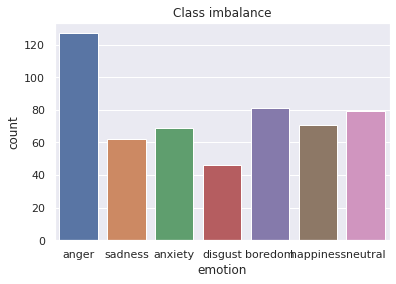

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# class imbalance plot
print(df['emotion'].unique())
plt.figure(figsize = (12,6))
sns.set_theme(style='darkgrid')
sns.countplot(x = 'emotion', data = df)
plt.title('Class imbalance')
plt.savefig(imgsPath + 'class_imbalance.png')
plt.show()

## waveform

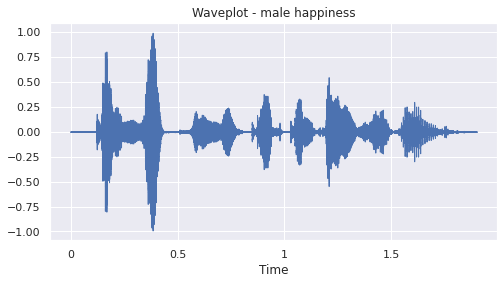

In [15]:
import librosa.display

# waveplot
wavf, sr = librosa.load('../data/emodb/wav/03a01Fa.wav')

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - male happiness')
plt.savefig(imgsPath + 'waveplot_male_happiness.png')
plt.show()

## log-mel spectrogram

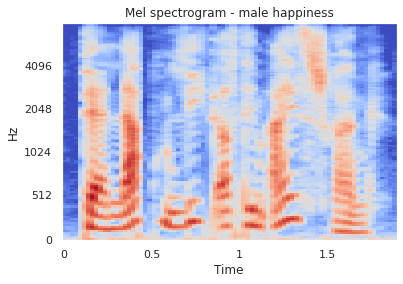

In [16]:
# log-mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram - male happiness')
plt.savefig(imgsPath + 'mel_spec_male_happiness.png')
plt.show()

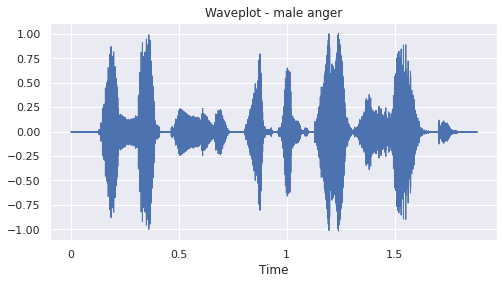

In [17]:
# waveplot
wavf, sr = librosa.load('../data/emodb/wav/03a01Wa.wav')

plt.figure(figsize = (8, 4))
librosa.display.waveshow(wavf, sr = sr)
plt.title('Waveplot - male anger')
plt.savefig(imgsPath + 'waveplot_male_anger.png')
plt.show()

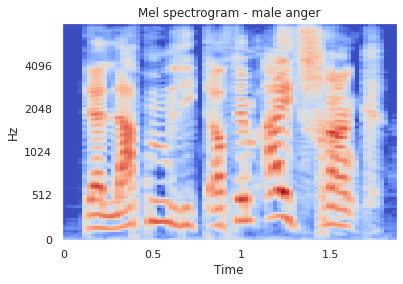

In [18]:
# log-mel spectrogram
spectrogram = librosa.feature.melspectrogram(y=wavf, sr=sr, n_mels=128, fmax=8000)
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time')
plt.title('Mel spectrogram - male anger')
plt.savefig(imgsPath + 'mel_spec_male_anger.png')
plt.show()

# Feature extraction

In [21]:
import librosa

# mfcc features extraction

logMelSpecVal = []

def parse_audio_file(pathToFile, _duration, sampleRate):
    # load file
    wavf, sample_rate = librosa.load(pathToFile, res_type="kaiser_fast", sr=sampleRate, duration=_duration)
    
    # get mfcc features (coefficients = 13, filters = 32)
    mfcc = np.array([])
    mfcc = np.mean(librosa.feature.mfcc(y=wavf, sr=sample_rate, n_mfcc = 13), axis=0)
    
    return mfcc

mfccVal = []

for fpath in df['path']:
    mfcc = parse_audio_file(fpath, 3, 44100)
    mfccVal.append(mfcc)
    
# merge emotions with features
df = pd.concat([df, pd.DataFrame(mfccVal)], axis=1)
    
# drop unnecessary column
df.drop(columns='path', inplace=True)

# fill na's
df = df.fillna(0)
df.head()

,emotion,0,1,2,3,4,5,6,7,8,...,249,250,251,252,253,254,255,256,257,258
0,anger,-36.090981,-32.796627,-31.116634,-29.469265,-29.919529,-33.353619,-34.865524,-19.824419,-11.663167,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,sadness,-26.888803,-24.913523,-24.717571,-25.344395,-26.282381,-25.518589,-24.652832,-24.923763,-19.284304,...,-25.633877,-25.706993,-26.620176,-25.597450,-22.226006,-13.970099,-9.505075,-3.753060,2.319482,4.927014
2,anxiety,-26.956562,-27.515024,-26.380819,-25.832865,-27.194027,-26.763607,-28.808035,-27.407793,-14.827052,...,-25.638302,-28.189751,-28.497795,-27.321564,-30.589140,0.000000,0.000000,0.000000,0.000000,0.000000
3,sadness,-24.535583,-23.440098,-20.839142,-20.759388,-21.358418,-21.638031,-23.573610,-22.106655,-20.113008,...,-7.505963,-6.442713,-6.644028,-10.071915,-14.457645,-7.897094,-4.241241,-4.780592,-4.908673,-1.998444
4,disgust,-34.375870,-29.413809,-28.761814,-29.789680,-28.418623,-29.296476,-30.873238,-28.353069,-28.111835,...,-6.539373,-7.520744,-10.318470,-20.845755,-22.988085,-24.448378,-26.493479,-26.639347,-26.456181,-28.664257


# Data split

In [22]:
from sklearn.model_selection import train_test_split

def data_split(df):
    # divide data into labels and features
    X = df.iloc[:, :].drop(columns=['emotion'])
    y = df['emotion']
    
    # stratified train, test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = data_split(df)

print(X_train.head())
print(y_train.head())

           0          1          2          3          4          5    \
207 -27.812401 -26.095999 -27.213594 -27.161293 -27.330292 -26.838541   
30  -28.435099 -28.983267 -26.964230 -25.441334 -24.103260 -26.315037   
394 -42.649555 -42.649555 -31.655439 -20.547497 -15.695326 -15.310612   
113 -18.939081 -20.487501 -24.100132 -25.111996 -24.547939 -21.552578   
97  -21.188581 -18.269150 -17.762320 -15.500142 -12.583714 -11.241489   

           6          7          8          9    ...        249        250  \
207 -27.978889 -28.245817 -25.992981 -17.858311  ...   0.000000   0.000000   
30  -28.579914 -32.931412 -32.774189 -27.950102  ... -16.144505 -12.689244   
394 -15.609266 -16.477499 -12.790943 -12.542530  ...  -4.659929  -5.078440   
113 -20.105801 -22.067406 -17.724606 -13.535122  ...   0.000000   0.000000   
97  -13.649336 -13.101710 -13.460220 -12.464756  ...   0.000000   0.000000   

          251       252        253        254        255       256        257  \
207  0.0000

# Data preprocessing

In [23]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def data_preprocessing(X_train, X_test, y_train, y_test):

    # normalization (z-score, values between -1 and 1)
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

    # turn data into arrays for keras
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(y_train.shape)
    print(y_test.shape)

    # label one hot encoding
    lb = LabelEncoder()
    y_train = to_categorical(lb.fit_transform(y_train))
    y_test = to_categorical(lb.fit_transform(y_test))

    print(y_test[0:3])

    print(lb.classes_)

    # data reshaping
    X_train = X_train[:,:,np.newaxis]
    X_test = X_test[:,:,np.newaxis]

    print(X_train.shape)
    
    return X_train, X_test, y_train, y_test, lb

X_train, X_test, y_train, y_test, lb = data_preprocessing(X_train, X_test, y_train, y_test)

(428,)
(107,)
[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
['anger' 'anxiety' 'boredom' 'disgust' 'happiness' 'neutral' 'sadness']
(428, 259, 1)


# CNN model architecture

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.regularizers import l2

def get_model():
    #BUILD 1D CNN LAYERS
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(7, activation='sigmoid'))
    opt = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
    
    return model

model = get_model()
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 250, 64)           704       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 241, 128)          82048     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 30, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 21, 128)           163968    
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 2, 128)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128)           

# Model training and export


Epoch 00001: val_accuracy improved from -inf to 0.41121, saving model to ../models/emodb/model_1_CNN
INFO:tensorflow:Assets written to: ../models/emodb/model_1_CNN/assets

Epoch 00002: val_accuracy did not improve from 0.41121

Epoch 00003: val_accuracy improved from 0.41121 to 0.44860, saving model to ../models/emodb/model_1_CNN
INFO:tensorflow:Assets written to: ../models/emodb/model_1_CNN/assets

Epoch 00004: val_accuracy did not improve from 0.44860

Epoch 00005: val_accuracy improved from 0.44860 to 0.48598, saving model to ../models/emodb/model_1_CNN
INFO:tensorflow:Assets written to: ../models/emodb/model_1_CNN/assets

Epoch 00006: val_accuracy did not improve from 0.48598

Epoch 00007: val_accuracy did not improve from 0.48598

Epoch 00008: val_accuracy did not improve from 0.48598

Epoch 00009: val_accuracy did not improve from 0.48598

Epoch 00010: val_accuracy did not improve from 0.48598

Epoch 00011: val_accuracy did not improve from 0.48598

Epoch 00012: val_accuracy did

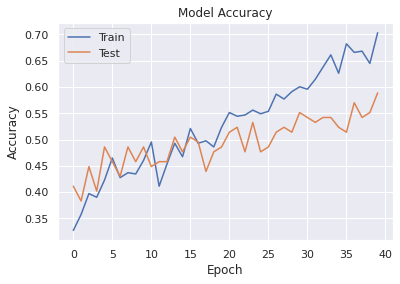

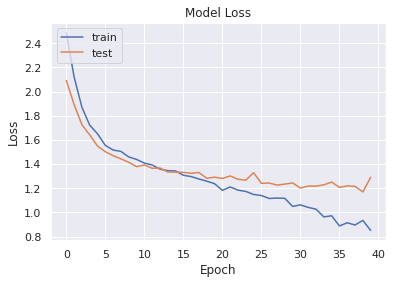

In [36]:
from keras.callbacks import ModelCheckpoint

# use checkpoints to save best model
checkpoint=ModelCheckpoint(modelsPath + 'model_1_CNN', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# fit model
model_history=model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test), callbacks=[checkpoint], verbose=0)

# plot model accuracy and loss over epochs
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig(imgsPath + 'Initial_Model_Accuracy.png')
plt.show()

# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(imgsPath + 'Initial_Model_loss.png')
plt.show()

# Results

## accuracy and loss

In [37]:
# loss and accuracy percentage on test set
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

4/4 [==============================] - 0s 3ms/step - loss: 1.2910 - accuracy: 0.5888
Loss of the model is -  1.2909846305847168
4/4 [==============================] - 0s 2ms/step - loss: 1.2910 - accuracy: 0.5888
Accuracy of the model is -  58.87850522994995 %


In [38]:
# predictions
predictions = model.predict(X_test)
predictions = predictions.argmax(axis=1)
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# actual labels
actual = y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# combine both
finaldf = actual.join(predictions)
finaldf[1:10]

,Actual Values,Predicted Values
1,boredom,anxiety
2,neutral,neutral
3,happiness,anger
4,happiness,happiness
5,anxiety,anxiety
6,anxiety,neutral
7,happiness,anger
8,happiness,anger
9,neutral,neutral


## confusion matrix

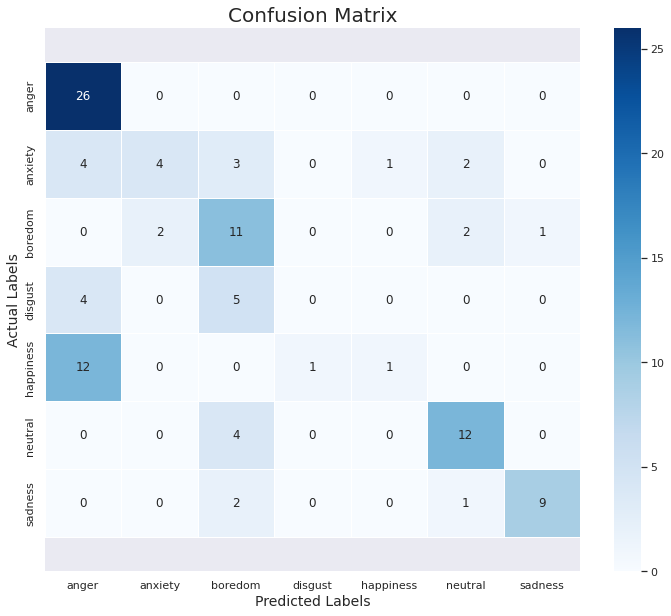

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

# confusion matrix, actual vs predicted
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig(imgsPath + 'Initial_Model_Confusion_Matrix.png')
plt.show()

In [40]:
print(classification_report(actual, predictions, target_names = ['angry','anxiety','boredom','disgust','happiness','neutral','sadness']))

              precision    recall  f1-score   support

       angry       0.57      1.00      0.72        26
     anxiety       0.67      0.29      0.40        14
     boredom       0.44      0.69      0.54        16
     disgust       0.00      0.00      0.00         9
   happiness       0.50      0.07      0.12        14
     neutral       0.71      0.75      0.73        16
     sadness       0.90      0.75      0.82        12

    accuracy                           0.59       107
   macro avg       0.54      0.51      0.48       107
weighted avg       0.56      0.59      0.52       107

